In [20]:
# Imports
import math
import numpy as np
import pandas as pd
import plotly.express as px
import os
import git
import statsmodels
import statsmodels.formula.api as smf
# Filepaths
repo = git.Repo('.', search_parent_directories=True)
os.chdir(repo.working_tree_dir)
print(os.getcwd())
# Data
Chalk_Long = pd.read_excel('data/Raw/Chalk_Long.xlsm', sheet_name=1, header=0)
metadata = pd.read_excel('data/Raw/Metadata.xlsx', sheet_name=1, header=0)
Chalk = pd.merge(metadata, Chalk_Long, on=["Code","bChalk"], how='left')
Chalk["Chalk"] = Chalk["Chalk"].astype("category")
Chalk["Chalk"] = Chalk["Chalk"].cat.rename_categories(["None", "FL", "Metolius", "Magdust", "Ethan"])
Chalk["Person"] = Chalk["Person"].astype("category")
Chalk["Pinch_Order"] = Chalk["Pinch_Order"].rank(method='dense')
Chalk["Day_Chalk"] = Chalk["Day"].astype("str") + "_" + Chalk["Chalk"].astype("str")

c:\Users\Public\Documents\Personal_Projects\Ethan_Chalk_Project


# Diagnostic Plots

In [21]:
# Scipy's LR diagnostics
# base code
import numpy as np
import seaborn as sns
from statsmodels.tools.tools import maybe_unwrap_results
from statsmodels.graphics.gofplots import ProbPlot
from statsmodels.stats.outliers_influence import variance_inflation_factor
import matplotlib.pyplot as plt
from typing import Type

style_talk = 'seaborn-talk'    #refer to plt.style.available

class LinearRegDiagnostic():
    """
    Diagnostic plots to identify potential problems in a linear regression fit.
    Mainly,
        a. non-linearity of data
        b. Correlation of error terms
        c. non-constant variance
        d. outliers
        e. high-leverage points
        f. collinearity

    Authors:
        Prajwal Kafle (p33ajkafle@gmail.com, where 3 = r)
        Does not come with any sort of warranty.
        Please test the code one your end before using.

        Matt Spinelli (m3spinelli@gmail.com, where 3 = r)
        (1) Fixed incorrect annotation of the top most extreme residuals in
            the Residuals vs Fitted and, especially, the Normal Q-Q plots.
        (2) Changed Residuals vs Leverage plot to match closer the y-axis
            range shown in the equivalent plot in the R package ggfortify.
        (3) Added horizontal line at y=0 in Residuals vs Leverage plot to
            match the plots in R package ggfortify and base R.
        (4) Added option for placing a vertical guideline on the Residuals
            vs Leverage plot using the rule of thumb of h = 2p/n to denote
            high leverage (high_leverage_threshold=True).
        (5) Added two more ways to compute the Cook's Distance (D) threshold:
            * 'baseR': D > 1 and D > 0.5 (default)
            * 'convention': D > 4/n
            * 'dof': D > 4 / (n - k - 1)
        (6) Fixed class name to conform to Pascal casing convention
        (7) Fixed Residuals vs Leverage legend to work with loc='best'
    """

    def __init__(self,
                 results: Type[statsmodels.regression.linear_model.RegressionResultsWrapper]) -> None:
        """
        For a linear regression model, generates following diagnostic plots:

        a. residual
        b. qq
        c. scale location and
        d. leverage

        and a table

        e. vif

        Args:
            results (Type[statsmodels.regression.linear_model.RegressionResultsWrapper]):
                must be instance of statsmodels.regression.linear_model object

        Raises:
            TypeError: if instance does not belong to above object

        Example:
        >>> import numpy as np
        >>> import pandas as pd
        >>> import statsmodels.formula.api as smf
        >>> x = np.linspace(-np.pi, np.pi, 100)
        >>> y = 3*x + 8 + np.random.normal(0,1, 100)
        >>> df = pd.DataFrame({'x':x, 'y':y})
        >>> res = smf.ols(formula= "y ~ x", data=df).fit()
        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls(plot_context="seaborn-v0_8-paper")

        In case you do not need all plots you can also independently make an individual plot/table
        in following ways

        >>> cls = Linear_Reg_Diagnostic(res)
        >>> cls.residual_plot()
        >>> cls.qq_plot()
        >>> cls.scale_location_plot()
        >>> cls.leverage_plot()
        >>> cls.vif_table()
        """

        if isinstance(results, statsmodels.regression.linear_model.RegressionResultsWrapper) is False:
            raise TypeError("result must be instance of statsmodels.regression.linear_model.RegressionResultsWrapper object")

        self.results = maybe_unwrap_results(results)

        self.y_true = self.results.model.endog
        self.y_predict = self.results.fittedvalues
        self.xvar = self.results.model.exog
        self.xvar_names = self.results.model.exog_names

        self.residual = np.array(self.results.resid)
        influence = self.results.get_influence()
        self.residual_norm = influence.resid_studentized_internal
        self.leverage = influence.hat_matrix_diag
        self.cooks_distance = influence.cooks_distance[0]
        self.nparams = len(self.results.params)
        self.nresids = len(self.residual_norm)

    def __call__(self, plot_context='seaborn-v0_8-paper', **kwargs):
        # print(plt.style.available)
        # GH#9157
        if plot_context not in plt.style.available:
            plot_context = 'default'
        with plt.style.context(plot_context):
            fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(10,10))
            self.residual_plot(ax=ax[0,0])
            self.qq_plot(ax=ax[0,1])
            self.scale_location_plot(ax=ax[1,0])
            self.leverage_plot(
                ax=ax[1,1],
                high_leverage_threshold = kwargs.get('high_leverage_threshold'),
                cooks_threshold = kwargs.get('cooks_threshold'))
            plt.show()

        return self.vif_table(), fig, ax,

    def residual_plot(self, ax=None):
        """
        Residual vs Fitted Plot

        Graphical tool to identify non-linearity.
        (Roughly) Horizontal red line is an indicator that the residual has a linear pattern
        """
        if ax is None:
            fig, ax = plt.subplots()

        sns.residplot(
            x=self.y_predict,
            y=self.residual,
            lowess=True,
            scatter_kws={'alpha': 0.5},
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        residual_abs = np.abs(self.residual)
        abs_resid = np.flip(np.argsort(residual_abs), 0)
        abs_resid_top_3 = abs_resid[:3]
        for i in abs_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], self.residual[i]),
                color='C3')

        ax.set_title('Residuals vs Fitted', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel('Residuals')
        return ax

    def qq_plot(self, ax=None):
        """
        Standarized Residual vs Theoretical Quantile plot

        Used to visually check if residuals are normally distributed.
        Points spread along the diagonal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        QQ = ProbPlot(self.residual_norm)
        fig = QQ.qqplot(line='45', alpha=0.5, lw=1, ax=ax)

        # annotations
        abs_norm_resid = np.flip(np.argsort(np.abs(self.residual_norm)), 0)
        abs_norm_resid_top_3 = abs_norm_resid[:3]
        for i, x, y in self.__qq_top_resid(QQ.theoretical_quantiles, abs_norm_resid_top_3):
            ax.annotate(
                i,
                xy=(x, y),
                ha='right',
                color='C3')

        ax.set_title('Normal Q-Q', fontweight="bold")
        ax.set_xlabel('Theoretical Quantiles')
        ax.set_ylabel('Standardized Residuals')
        return ax

    def scale_location_plot(self, ax=None):
        """
        Sqrt(Standarized Residual) vs Fitted values plot

        Used to check homoscedasticity of the residuals.
        Horizontal line will suggest so.
        """
        if ax is None:
            fig, ax = plt.subplots()

        residual_norm_abs_sqrt = np.sqrt(np.abs(self.residual_norm))

        ax.scatter(self.y_predict, residual_norm_abs_sqrt, alpha=0.5);
        sns.regplot(
            x=self.y_predict,
            y=residual_norm_abs_sqrt,
            scatter=False, ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        abs_sq_norm_resid = np.flip(np.argsort(residual_norm_abs_sqrt), 0)
        abs_sq_norm_resid_top_3 = abs_sq_norm_resid[:3]
        for i in abs_sq_norm_resid_top_3:
            ax.annotate(
                i,
                xy=(self.y_predict[i], residual_norm_abs_sqrt[i]),
                color='C3')

        ax.set_title('Scale-Location', fontweight="bold")
        ax.set_xlabel('Fitted values')
        ax.set_ylabel(r'$\sqrt{|\mathrm{Standardized\ Residuals}|}$');
        return ax

    def leverage_plot(self, ax=None, high_leverage_threshold=False, cooks_threshold='baseR'):
        """
        Residual vs Leverage plot

        Points falling outside Cook's distance curves are considered observation that can sway the fit
        aka are influential.
        Good to have none outside the curves.
        """
        if ax is None:
            fig, ax = plt.subplots()

        ax.scatter(
            self.leverage,
            self.residual_norm,
            alpha=0.5);

        sns.regplot(
            x=self.leverage,
            y=self.residual_norm,
            scatter=False,
            ci=False,
            lowess=True,
            line_kws={'color': 'red', 'lw': 1, 'alpha': 0.8},
            ax=ax)

        # annotations
        leverage_top_3 = np.flip(np.argsort(self.cooks_distance), 0)[:3]
        for i in leverage_top_3:
            ax.annotate(
                i,
                xy=(self.leverage[i], self.residual_norm[i]),
                color = 'C3')

        factors = []
        if cooks_threshold == 'baseR' or cooks_threshold is None:
            factors = [1, 0.5]
        elif cooks_threshold == 'convention':
            factors = [4/self.nresids]
        elif cooks_threshold == 'dof':
            factors = [4/ (self.nresids - self.nparams)]
        else:
            raise ValueError("threshold_method must be one of the following: 'convention', 'dof', or 'baseR' (default)")
        for i, factor in enumerate(factors):
            label = "Cook's distance" if i == 0 else None
            xtemp, ytemp = self.__cooks_dist_line(factor)
            ax.plot(xtemp, ytemp, label=label, lw=1.25, ls='--', color='red')
            ax.plot(xtemp, np.negative(ytemp), lw=1.25, ls='--', color='red')

        if high_leverage_threshold:
            high_leverage = 2 * self.nparams / self.nresids
            if max(self.leverage) > high_leverage:
                ax.axvline(high_leverage, label='High leverage', ls='-.', color='purple', lw=1)

        ax.axhline(0, ls='dotted', color='black', lw=1.25)
        ax.set_xlim(0, max(self.leverage)+0.01)
        ax.set_ylim(min(self.residual_norm)-0.1, max(self.residual_norm)+0.1)
        ax.set_title('Residuals vs Leverage', fontweight="bold")
        ax.set_xlabel('Leverage')
        ax.set_ylabel('Standardized Residuals')
        plt.legend(loc='best')
        return ax

    def vif_table(self):
        """
        VIF table

        VIF, the variance inflation factor, is a measure of multicollinearity.
        VIF > 5 for a variable indicates that it is highly collinear with the
        other input variables.
        """
        vif_df = pd.DataFrame()
        vif_df["Features"] = self.xvar_names
        vif_df["VIF Factor"] = [variance_inflation_factor(self.xvar, i) for i in range(self.xvar.shape[1])]

        return (vif_df
                .sort_values("VIF Factor")
                .round(2))


    def __cooks_dist_line(self, factor):
        """
        Helper function for plotting Cook's distance curves
        """
        p = self.nparams
        formula = lambda x: np.sqrt((factor * p * (1 - x)) / x)
        x = np.linspace(0.001, max(self.leverage), 50)
        y = formula(x)
        return x, y


    def __qq_top_resid(self, quantiles, top_residual_indices):
        """
        Helper generator function yielding the index and coordinates
        """
        offset = 0
        quant_index = 0
        previous_is_negative = None
        for resid_index in top_residual_indices:
            y = self.residual_norm[resid_index]
            is_negative = y < 0
            if previous_is_negative == None or previous_is_negative == is_negative:
                offset += 1
            else:
                quant_index -= offset
            x = quantiles[quant_index] if is_negative else np.flip(quantiles, 0)[quant_index]
            quant_index += 1
            previous_is_negative = is_negative
            yield resid_index, x, y


# Regression

- From our EDA we have generally shown that there appears to be good separation from chalk and person, and negligible for pinch order and day order. However, we cannot avoid confonding of chalk and day. 
- The data is also somewhat group unbalanced, with control being overrepresented. Linearity looks fine, but not homoscedasticity. 

First I want to test if our blocking variable is significantly different, by collapsing all chalks into one. 

In [22]:
Chalk["Used"] = [0 if c== "None" else 1 for c in Chalk["Chalk"]]
Chalk["Used"] = Chalk["Used"].astype("category")
Chalk["Used"] = Chalk["Used"].cat.rename_categories(["None", "Chalk"])

In [49]:
# Now Fit Mixed Model
testrel = smf.mixedlm("Pull ~ Pinch + Used + Person + Pinch_Order + Day_Order",
                      groups = "Day",
                      data = Chalk)
testrelf = testrel.fit()
print(testrelf.summary())


         Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: Pull      
No. Observations: 576     Method:             REML      
No. Groups:       7       Scale:              34.0774   
Min. group size:  60      Log-Likelihood:     -1842.6574
Max. group size:  114     Converged:          Yes       
Mean group size:  82.3                                  
--------------------------------------------------------
              Coef.  Std.Err.   z    P>|z| [0.025 0.975]
--------------------------------------------------------
Intercept     -6.075    1.350 -4.498 0.000 -8.721 -3.428
Used[T.Chalk]  9.891    0.492 20.122 0.000  8.927 10.854
Person[T.2]   -4.999    0.502 -9.966 0.000 -5.982 -4.016
Pinch          9.803    0.142 69.155 0.000  9.525 10.081
Pinch_Order    0.285    0.298  0.956 0.339 -0.299  0.869
Day_Order     -0.031    0.028 -1.091 0.275 -0.087  0.025
Day Var        5.867    0.632                           



In [45]:
# Now Fit Mixed Model
testrel = smf.mixedlm("Pull ~ Pinch + Used",
                      groups = "Day",
                      data = Chalk)
testrelf = testrel.fit(method=["lbfgs"])
print(testrelf.summary())



                 Mixed Linear Model Regression Results
Model:                   MixedLM       Dependent Variable:       Pull   
No. Observations:        576           Method:                   REML   
No. Groups:              7             Scale:                    39.4242
Min. group size:         60            Log-Likelihood:           inf    
Max. group size:         114           Converged:                Yes    
Mean group size:         82.3                                           
------------------------------------------------------------------------
              Coef.   Std.Err.     z    P>|z|     [0.025       0.975]   
------------------------------------------------------------------------
Intercept     0.000 48655366.411  0.000 1.000 -95362765.821 95362765.821
Used[T.Chalk] 9.962        0.529 18.833 0.000         8.925       10.999
Pinch         9.755        0.152 63.996 0.000         9.456       10.053
Day Var       0.000                                                  

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:1634: UserWarning:

Random effects covariance is singular

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2054: UserWarning:

The random effects covariance matrix is singular.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2237: ConvergenceWarning:

The MLE may be on the boundary of the parameter space.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2245: UserWarning:

The random effects covariance matrix is singular.

c:\Users\yujer\anaconda3\envs\main\Lib\site-packages\statsmodels\regression\mixed_linear_model.py:2261: ConvergenceWarning:

The Hessian matrix at the estimated parameter values is not positive definite.



In [50]:
testrelresid = px.scatter(x = testrelf.fittedvalues,
                          y = testrelf.resid,
                          title = "Residuals",
                          labels = {"x": "Value", "y": "Residuals"})
testrelresid.show()

# Vary Very Clear Homoscedasticity

In [51]:
# Get the residuals and the exogenous variables (design matrix)
residuals = testrelf.resid
exog = testrelf.model.exog

# Perform the Breusch-Pagan test
bp_test = statsmodels.stats.diagnostic.het_breuschpagan(residuals, exog)

# Print the test results
bp_test_results = {
    'Lagrange multiplier statistic': bp_test[0],
    'p-value': bp_test[1],
    'f-value': bp_test[2],
    'f p-value': bp_test[3]
}

print(bp_test_results)

# Affirmed w Breusch-Pagan Test

{'Lagrange multiplier statistic': np.float64(34.4646716976867), 'p-value': np.float64(1.9239790411266744e-06), 'f-value': np.float64(7.255247013806876), 'f p-value': np.float64(1.3347828850717373e-06)}


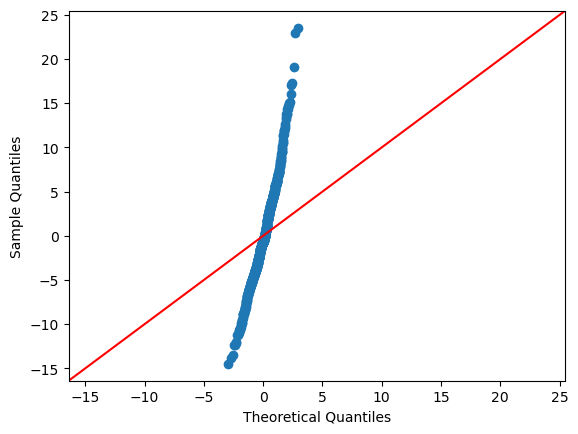

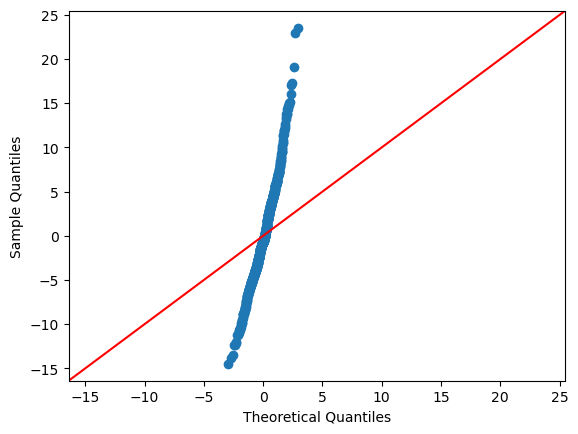

In [59]:
sm.qqplot(testrelf.resid, line = "45")

In [55]:

name = ["Chi^2", "Two-tail probability"]
test = statsmodels.stats.api.omni_normtest(testrelf.resid)
list(zip(name, test))

[('Chi^2', np.float64(37.44373460107716)),
 ('Two-tail probability', np.float64(7.399397192416869e-09))]

In [13]:
Chalk["Used"].info
Chalk["Chalk"].info

<bound method Series.info of 0       None
1       None
2       None
3         FL
4         FL
       ...  
571    Ethan
572    Ethan
573     None
574     None
575     None
Name: Chalk, Length: 576, dtype: category
Categories (5, object): ['None', 'FL', 'Metolius', 'Magdust', 'Ethan']>